### Install modules in terminal

In [74]:
%pip install pandas scikit-learn numpy hmmlearn matplotlib

Note: you may need to restart the kernel to use updated packages.


### Import modules

In [75]:
import pandas as pd

import numpy as np

import hmmlearn.hmm
from hmmlearn.hmm import MultinomialHMM, GaussianHMM

import matplotlib.pyplot as plt

### HMM Model with 2024 data

In [76]:
training_df = pd.read_csv("../datasets/BTCUSDT_train_features.csv")

print(training_df)


                 timestamp      open      high       low     close  \
0      2018-01-01 17:00:00  13093.10  13248.60  13093.09  13138.11   
1      2018-01-01 18:00:00  13138.12  13321.23  13114.47  13189.98   
2      2018-01-01 19:00:00  13189.98  13350.00  13156.91  13345.47   
3      2018-01-01 20:00:00  13345.47  13544.24  13345.46  13469.01   
4      2018-01-01 21:00:00  13469.01  13772.59  13432.00  13565.00   
...                    ...       ...       ...       ...       ...   
26942  2021-01-29 11:00:00  36686.34  37307.28  36491.79  37108.69   
26943  2021-01-29 12:00:00  37106.18  37988.28  36622.22  37967.31   
26944  2021-01-29 13:00:00  37967.74  38570.13  37171.79  38458.99   
26945  2021-01-29 14:00:00  38499.99  38534.47  36570.00  37185.49   
26946  2021-01-29 15:00:00  37185.49  37619.92  36868.50  37178.27   

            volume        rsi         macd        ema_12        ema_26  \
0       380.269338  35.795321  -191.147212  13323.908819  13515.056031   
1       552

In [77]:
# Load your data
df = training_df

# Convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by time just in case
df = df.sort_values('timestamp')


# Drop NaN from the first row (due to shift)
df = df.dropna()

# Prepare observation sequence (log returns and normalized volume)
df['volume_norm'] = (df['volume'] - df['volume'].mean()) / df['volume'].std()


observations = df[['log_return', 'volume_norm']].values


# Fit a Gaussian HMM with N hidden states
hmmodel = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000) 
hmmodel.fit(observations)

# Predict the hidden states
hidden_states = hmmodel.predict(observations)

# Add hidden states to dataframe
df['state'] = hidden_states

print(df[['timestamp', 'open', 'close', 'log_return', 'state']])


                timestamp      open     close  log_return  state
0     2018-01-01 17:00:00  13093.10  13138.11    0.003432      0
1     2018-01-01 18:00:00  13138.12  13189.98    0.003940      0
2     2018-01-01 19:00:00  13189.98  13345.47    0.011720      0
3     2018-01-01 20:00:00  13345.47  13469.01    0.009214      0
4     2018-01-01 21:00:00  13469.01  13565.00    0.007101      0
...                   ...       ...       ...         ...    ...
26942 2021-01-29 11:00:00  36686.34  37108.69    0.011150      2
26943 2021-01-29 12:00:00  37106.18  37967.31    0.022874      2
26944 2021-01-29 13:00:00  37967.74  38458.99    0.012867      2
26945 2021-01-29 14:00:00  38499.99  37185.49   -0.033674      2
26946 2021-01-29 15:00:00  37185.49  37178.27   -0.000194      2

[26947 rows x 5 columns]


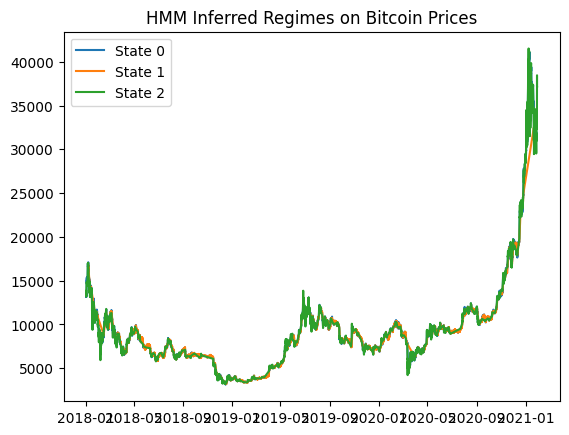

In [78]:
for i in range(hmmodel.n_components):
    state_series = df[df['state'] == i]
    plt.plot(state_series['timestamp'], state_series['close'], label=f'State {i}')

    #the state 0 represents a bear market (steady growth with low volatility) and state 1 represents a bull market (downward trend and high volatility)

plt.legend()
plt.title("HMM Inferred Regimes on Bitcoin Prices")
plt.show()

### Identify the meaning of the state number

In [84]:
# Calculate average return, volatility, and volume per state
state_analysis = df.groupby('state').agg({
    'log_return': ['mean', 'std'],
    'volume_norm': 'mean'
})

# Calculate the relative frequency (percentage) of each state
state_percentages = df['state'].value_counts(normalize=True) * 100

print("Percentage of each state:")
print(state_percentages)


print("\n=== State Analysis (to identify the meaning of each state, the highest the log return, the market is bullish) === ")
print(state_analysis)

# Determine which state is most bullish (highest average return)
bullish_state = state_analysis['log_return']['mean'].idxmax()
print("\nState considered Bullish =", bullish_state)

# Determine which state is most bearish (lowest average return)
bearish_state = state_analysis['log_return']['mean'].idxmin()
print("State considered Bearish =", bearish_state)

# Determine the Neutral state (neither max nor min return)
neutral_state = list(set(df['state'].unique()) - {bullish_state, bearish_state})[0]
print("State considered Neutral =", neutral_state)

# Add market_state labels based on analysis
state_mapping = {
    bullish_state: 'bullish',
    bearish_state: 'bearish',
    neutral_state: 'neutral'
}
df['market_state'] = df['state'].map(state_mapping)
print(df[['timestamp', 'open', 'close', 'log_return', 'state', 'market_state']])


Percentage of each state:
state
1    51.671800
0    37.265744
2    11.062456
Name: proportion, dtype: float64

=== State Analysis (to identify the meaning of each state, the highest the log return, the market is bullish) === 
      log_return           volume_norm
            mean       std        mean
state                                 
0       0.000222  0.006766    0.057107
1       0.000054  0.002612   -0.472346
2      -0.000648  0.022410    2.013913

State considered Bullish = 0
State considered Bearish = 2
State considered Neutral = 1
                timestamp      open     close  log_return  state market_state
0     2018-01-01 17:00:00  13093.10  13138.11    0.003432      0      bullish
1     2018-01-01 18:00:00  13138.12  13189.98    0.003940      0      bullish
2     2018-01-01 19:00:00  13189.98  13345.47    0.011720      0      bullish
3     2018-01-01 20:00:00  13345.47  13469.01    0.009214      0      bullish
4     2018-01-01 21:00:00  13469.01  13565.00    0.007101     

### Simple Prediction Example

In [ ]:
# Example data
today_close = 44957.63
yesterday_close = 44122.03
today_vol = 46593616092.15278
volume_mean = df['volume'].mean()
volume_std = df['volume'].std()

# Calculate features
log_return = np.log(today_close / yesterday_close)
volume_norm = (today_vol - volume_mean) / volume_std

# Format as 2D array
new_obs = np.array([[log_return, volume_norm]])

# Predict hidden state
state_today = hmmodel.predict(new_obs)

print(f"Predicted hidden state: {state_today[0]}")


Predicted hidden state: 2
